In [1]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sc import *
from plot import *
from tqdm import tqdm
from alg import hstar, k_rollout, bhattacharya, almost_equal
from pqdict import pqdict
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [2]:
folder = "../exp3_data2"
results_dict = np.load(f"{folder}/setup.npz", allow_pickle=True)
alphas, SCs, ref_outputs, hole_locs = [results_dict[x] for x in results_dict.keys()]

N = 9

data_reg   = [np.load(f"{folder}/data_steps0_batch{i}.npz", allow_pickle=True)["data"] for i in range(N)]
data_roll  = [np.load(f"{folder}/data_steps1_batch{i}.npz", allow_pickle=True)["data"] for i in range(N)]
data_prune = [np.load(f"{folder}/data_prune_steps1_batch{i}.npz", allow_pickle=True)["data"] for i in range(N)]
data_bhat  = [np.load(f"{folder}/data_bhat_batch_{i}.npz", allow_pickle=True)["data"] for i in range(N)]

In [19]:
colors = ['#4daf4a', '#984ea3', '#f781bf', '#ff7f00', '#377eb8', '#ff7f00', '#a65628', '#999999', '#e41a1c', '#dede00']

In [73]:
def get_transitions(path_arr, ref_path, eps=1e-10):
    proj_arr = np.array([ref_path.proj_diff(x) for x in path_arr])
    # np.linalg.norm(x.proj - ref_path.proj, 2) for x in path_arr])
    proj_grad = proj_arr[:-1] - proj_arr[1:]
    transitions = [0] + list(np.where(proj_grad > eps)[0] + 1) + [len(path_arr)]
    return transitions

def identify_class(heuristic_paths, bhat_paths, eps=1e-5):
    corresponding_shortest = []
    for i, path_i in enumerate(heuristic_paths):
        for j, path_j in enumerate(bhat_paths):
            if almost_equal(path_i.proj, path_j.proj, eps):
                corresponding_shortest.append(path_j)
                break
    return corresponding_shortest

def get_best_paths(paths, bounds, num_visited, eps=1e-5):
    best_paths, best_idxs = [], []
    path_lens = [x.weight for x in paths]
    for i, left in enumerate(bounds[:-1]):
        right = bounds[i+1]
        sub_arr = path_lens[left:right]
        best_idx = left+np.argmin(sub_arr)
        best_cost = path_lens[best_idx]
        all_nodes_w_best_cost = np.array([(left+i, num_visited[left+i]) for (i, x) in enumerate(sub_arr) if np.abs(best_cost - x) < eps])
        print(all_nodes_w_best_cost[-1])
        best_idx = int(all_nodes_w_best_cost[np.argmin(all_nodes_w_best_cost[:,1]),0])
        best_path = paths[best_idx]
        best_paths.append(best_path)
        best_idxs.append(best_idx)

    return best_paths, best_idxs

def assign_colors_to_paths(paths1, paths2, paths3, colors, decimals):
    paths = paths1 + paths2 + paths3
    color_dict = {}
    k = 1
    assigned_colors = [None] * len(paths)
    for i, x in enumerate(paths):
        proj_x = tuple(np.round(x.proj, decimals))
        if proj_x in color_dict:
            assigned_colors[i] = color_dict[proj_x]
        if proj_x not in color_dict:
            k += 1
            color_dict[proj_x] = colors[k]
            assigned_colors[i] = colors[k]

    n1, n2, n3 = len(paths1), len(paths2), len(paths3)

    path1_colors = colors[:2] + assigned_colors[:n1]
    path2_colors = colors[:2] + assigned_colors[n1:n1+n2]
    path3_colors = colors[:2] + assigned_colors[n1+n2:]

    return path1_colors, path2_colors, path3_colors, color_dict

In [4]:
folder = "../exp3_data2"

def get_hole_coords(n_side, row_col_coords):
    delta = 2 / (n_side - 1)
    return np.array([np.array(x) * delta - (1, 1) for x in row_col_coords])

n_side = 19

node_coords = [(n_side//2,n_side//2), (4, 4),  (n_side-5, 4),  (n_side-5, n_side-5),  (4, n_side-5), (4, n_side//2), (n_side-5, n_side//2), (n_side//2, 4), (n_side//2, n_side-5)]
hole_locs = get_hole_coords(19, node_coords)

num_scs = len(hole_locs)
dx = 2 / (n_side - 1)
SCs = []

for i, loc in enumerate(hole_locs):
    SC_i = SimplicialComplex(n_side, False, False, True)
    SC_i.make_holes(hole_locs[:i+1,:], 1.5*dx)
    SCs.append(SC_i)

coords = [(-1, -1), (1, -1), (1,0), (-1, 0), (-1, 1), (1,1)]
ref_outputs = [Path(SC_i, path_from_coords(SCs[-1], coords)) for SC_i in SCs]

In [85]:
print(len(alphas))

20


In [81]:
# num_SCs = len(SCs)

N = len(SCs)
data_to_plot = np.zeros((N, 4, 3), object)

for i, (SC, ref_path_arr)  in enumerate(zip(SCs[:N], ref_outputs[:N])):
    ref_path = Path(SC, ref_path_arr)
    for j in range(3):
        alphas_j = alphas
        data_ij = (data_reg[i]) if (j == 0) else (data_roll[i] if (j == 1) else data_prune[i])
        paths_ij = [data_ij[k][0] for k in range(len(data_ij))]
        num_visited_ij = data_ij[:,3]
        path_proj_diffs = [ref_path.proj_diff(x) for x in paths_ij]
        trans_ij = get_transitions(paths_ij, ref_path)
        best_paths_ij, best_paths_idx = get_best_paths(paths_ij, trans_ij, num_visited_ij)
        best_data = [(alphas_j[k], np.round(paths_ij[k].weight, 2), np.round(path_proj_diffs[k], 2), data_ij[k][-1]) for k in best_paths_idx]
        data_to_plot[i,j,0] = data_ij[best_paths_idx[-1]][-2]
        data_to_plot[i,j,1] = paths_ij[best_paths_idx[-1]].weight
        data_to_plot[i,j,2] = paths_ij[best_paths_idx[-1]]
        print('-'*400)
    data_to_plot[i,3,0] = data_bhat[i][-2]
    data_to_plot[i,3,1] = data_bhat[i][0].weight
    data_to_plot[i,3,2] = data_bhat[i][0]

[ 11 300]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[   11 20465]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[   11 11593]
----------------------------------------------------------------------------------------------------------------------------------------------------------------

[    2 28537]
[    8 21336]
[    0 27414]
[    1 28490]
[    5 28227]
[  14 6524]


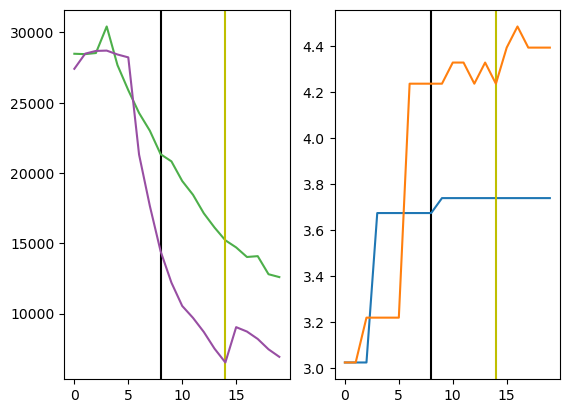

In [83]:
def get_best_paths(paths, bounds, num_visited, eps=1e-5):
    best_paths, best_idxs = [], []
    path_lens = [x.weight for x in paths]
    for i, left in enumerate(bounds[:-1]):
        right = bounds[i+1]
        sub_arr = path_lens[left:right]
        best_idx = left+np.argmin(sub_arr)
        best_cost = path_lens[best_idx]
        all_nodes_w_best_cost = np.array([(left+i, num_visited[left+i]) for (i, x) in enumerate(sub_arr) if np.abs(best_cost - x) < eps])
        print(all_nodes_w_best_cost[-1])
        best_idx = int(all_nodes_w_best_cost[np.argmin(all_nodes_w_best_cost[:,1]),0])
        best_path = paths[best_idx]
        best_paths.append(best_path)
        best_idxs.append(best_idx)

    return best_paths, best_idxs


fig, axs = plt.subplots(1,2)
for i in [2, 3]:
    j = 1
    ref_path = Path(SCs[i], ref_outputs[i])
    data_ij = (data_reg[3]) if (j == 0) else (data_roll[i] if (j == 1) else data_prune[i])
    num_visited_ij = data_ij[:,3]
    paths_ij = [data_ij[k][0] for k in range(len(data_ij))]
    path_proj_diffs = [ref_path.proj_diff(x) for x in paths_ij]
    trans_ij = get_transitions(paths_ij, ref_path)
    best_paths_ij, best_paths_idx = get_best_paths(paths_ij, trans_ij, num_visited_ij)
    # several_path_plot(SCs[i], data_ij[::5,0], None, None, [colors[4]] + colors)
    axs[0].axvline(best_paths_idx[-1], c='k' if i < 3 else 'y')
    axs[1].axvline(best_paths_idx[-1], c='k' if i < 3 else 'y')
    axs[0].plot(data_ij[:,3], c=colors[i-2])
    axs[1].plot([x.get_weight() for x in data_ij[:,0]])
    # axs[2].plot(data_ij[:,3]) 
plt.show()